In [2]:
import os
import pandas as pd
import configparser
import seaborn as sns

# Read config file
config = configparser.ConfigParser()
config.read('config.ini')

DATA_DIR = config['PATHS']['DATA_DIR']
IMG_DIR = os.path.join(DATA_DIR, 'dhs_images')

df = pd.read_csv(os.path.join(DATA_DIR, 'dhs_data.csv'))
df

,cluster_id,lon,lat,rural,region_id,country,survey,month,year,iwi
0,AO.Bengo.71.135,13.640789,-8.589805,False,AO.Bengo,Angola,Angola 2015-16 Standard DHS,11,2015,62.334459
1,AO.Bengo.71.158,14.122619,-7.718385,True,AO.Bengo,Angola,Angola 2015-16 Standard DHS,2,2016,8.226589
2,AO.Bengo.71.169,13.654425,-8.592545,False,AO.Bengo,Angola,Angola 2015-16 Standard DHS,10,2015,62.760211
3,AO.Bengo.71.203,13.517859,-8.652260,True,AO.Bengo,Angola,Angola 2015-16 Standard DHS,1,2016,68.211697
4,AO.Bengo.71.208,13.721998,-7.852511,True,AO.Bengo,Angola,Angola 2015-16 Standard DHS,11,2015,14.825944
...,...,...,...,...,...,...,...,...,...,...
69944,ZW.Midlands.72.37,30.008579,-20.911177,True,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,9,2015,27.791567
69945,ZW.Midlands.72.52,29.860028,-20.402214,True,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,10,2015,36.929878
69946,ZW.Midlands.72.69,30.172833,-20.724753,True,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,10,2015,24.406326
69947,ZW.Midlands.72.91,29.820084,-19.453466,False,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,7,2015,59.887344


Find samples without an image

In [7]:
def has_image(name):
    file_name = os.path.join(IMG_DIR, name, 'landsat_1_year_median.np')
    return os.path.exists(file_name)

df['has_image_1'] = df['cluster_id'].apply(has_image)

Show the places without any images

In [8]:
no_img_df = df[~df['has_image_1']]
no_img_df

,cluster_id,lon,lat,rural,region_id,country,survey,month,year,iwi,has_image,has_image_1
1255,BF.Center.21.1,-1.516700,12.366700,False,BF.Center,Burkina Faso,Burkina Faso 1993 Standard DHS,12,1992,39.469104,True,False
1256,BF.Center.21.10,-1.516700,12.366700,False,BF.Center,Burkina Faso,Burkina Faso 1993 Standard DHS,12,1992,34.923664,True,False
1257,BF.Center.21.11,-1.516700,12.366700,False,BF.Center,Burkina Faso,Burkina Faso 1993 Standard DHS,12,1992,35.948319,True,False
1258,BF.Center.21.12,-1.516700,12.366700,False,BF.Center,Burkina Faso,Burkina Faso 1993 Standard DHS,12,1992,32.784393,True,False
1259,BF.Center.21.13,-1.516700,12.366700,False,BF.Center,Burkina Faso,Burkina Faso 1993 Standard DHS,12,1992,28.491478,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
60175,TZ.Arusha.41.19,35.687296,-3.352569,False,TZ.Arusha,Tanzania,Tanzania 1999 Standard DHS,9,1999,21.708241,False,False
60177,TZ.Arusha.41.23,36.623485,-3.443452,True,TZ.Arusha,Tanzania,Tanzania 1999 Standard DHS,9,1999,17.205763,False,False
60181,TZ.Arusha.41.31,35.485617,-2.566482,True,TZ.Arusha,Tanzania,Tanzania 1999 Standard DHS,9,1999,14.335739,False,False
60848,TZ.Kagera.41.288,31.807187,-1.209702,True,TZ.Kagera,Tanzania,Tanzania 1999 Standard DHS,10,1999,15.931631,False,False


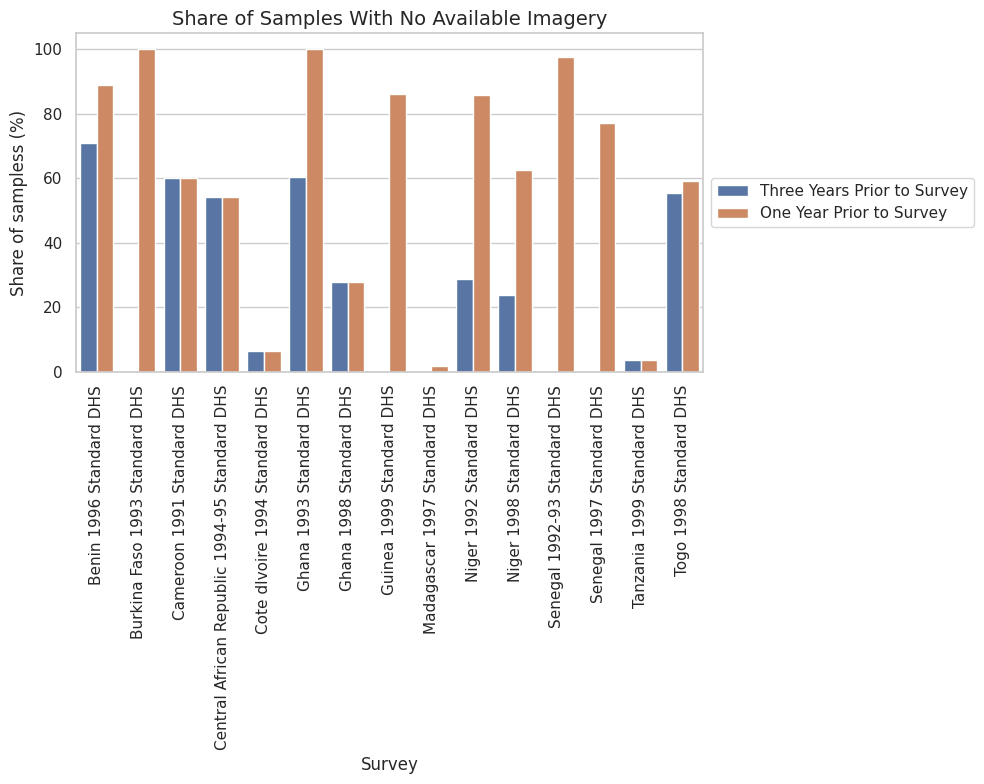

In [39]:
# Since surveys with 'has_image=False' will also have 'has_image_1=False', we can focus on 'has_image_1'.
missing_surveys = df.groupby('survey').apply(lambda x: (~x['has_image_1']).any()).reset_index()
missing_surveys = missing_surveys[missing_surveys[0]]['survey']

# Filter the DataFrame to include only surveys with some missingness
filtered_df = df[df['survey'].isin(missing_surveys)]

# Calculate missingness percentage
percentages = filtered_df.groupby('survey').agg(
    no_image_percentage=('has_image', lambda x: (~x).mean() * 100),
    no_image_1_percentage=('has_image_1', lambda x: (~x).mean() * 100)
).reset_index()

plot_data = pd.melt(percentages, id_vars=['survey'], 
                    value_vars=['no_image_percentage', 'no_image_1_percentage'], 
                    var_name='image_type', 
                    value_name='percentage')

# Replace labels for clarity
plot_data['image_type'] = plot_data['image_type'].map({
    'no_image_percentage': 'Three Years Prior to Survey',
    'no_image_1_percentage': 'One Year Prior to Survey'
})

plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")
sns.barplot(data=plot_data, x='survey', y='percentage', hue='image_type')

plt.title('Share of Samples With No Available Imagery', fontsize=14)
plt.xlabel('Survey', fontsize=12)
plt.ylabel('Share of sampless (%)', fontsize=12)
plt.xticks(rotation=90)#, ha='right')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.show()

**Important note**: For the remaining 150 surveys, every sample has at least some cloud-free imagery

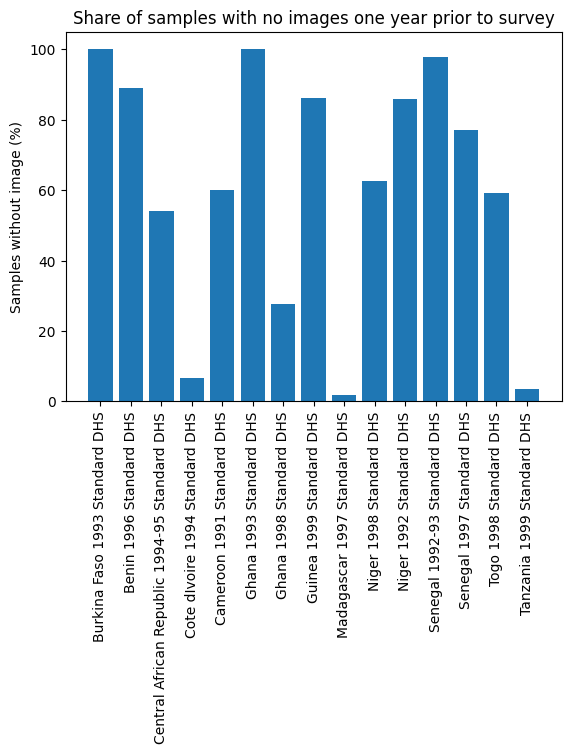

In [10]:
import matplotlib.pyplot as plt

surveys_with_missing = no_img_df['survey'].unique()
mean_1_percs = []

for x in surveys_with_missing:
    n_missing = len(no_img_df[no_img_df['survey'] == x])
    n_total = len(df[df['survey'] == x])
    perc_missing = 100 * (n_missing/n_total)
    mean_1_percs.append(perc_missing)

plt.bar(surveys_with_missing, mean_1_percs)
plt.title('Share of samples with no images one year prior to survey')
plt.ylabel('Samples without image (%)')
plt.xticks(rotation=90)
plt.show()

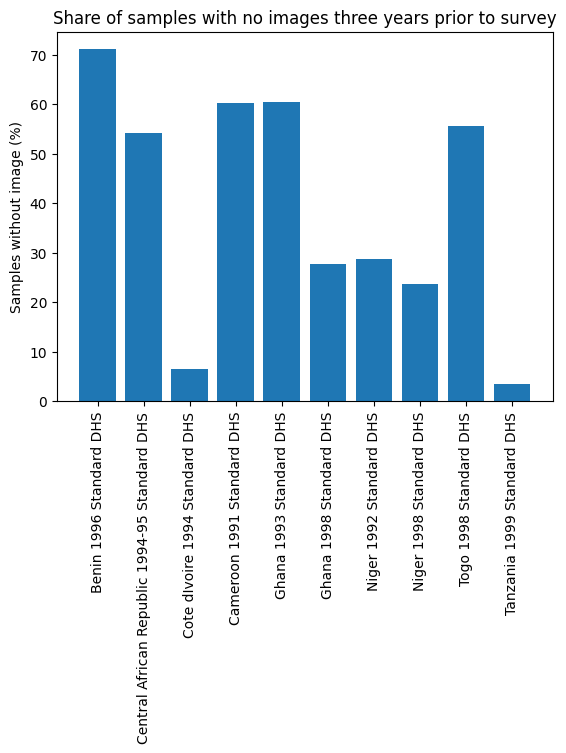

In [6]:
import matplotlib.pyplot as plt

surveys_with_missing = no_img_df['survey'].unique()
mean_3_percs = []

for x in surveys_with_missing:
    n_missing = len(no_img_df[no_img_df['survey'] == x])
    n_total = len(df[df['survey'] == x])
    perc_missing = 100 * (n_missing/n_total)
    mean_3_percs.append(perc_missing)

plt.bar(surveys_with_missing, mean_3_percs)
plt.title('Share of samples with no images three years prior to survey')
plt.ylabel('Samples without image (%)')
plt.xticks(rotation=90)
plt.show()

In [38]:
MISSING_PERC_THRESHOLD = 10

bad_surveys = []
for survey, perc in zip(surveys_with_missing, percs):
    if perc > MISSING_PERC_THRESHOLD:
        bad_surveys.append(survey)
        
clean_df = df[~df['survey'].isin(bad_surveys)] # Filter out bad surveys
clean_df = clean_df[clean_df['has_image']] # Filter out remaining samples without images
clean_df = clean_df.reset_index(drop=True).drop(columns=['has_image']) # Reset index and drop 'has_image' column
clean_df

,cluster_id,lon,lat,rural,region_id,country,survey,month,year,iwi
0,AO.Bengo.71.135,13.640789,-8.589805,False,AO.Bengo,Angola,Angola 2015-16 Standard DHS,11,2015,62.334459
1,AO.Bengo.71.158,14.122619,-7.718385,True,AO.Bengo,Angola,Angola 2015-16 Standard DHS,2,2016,8.226589
2,AO.Bengo.71.169,13.654425,-8.592545,False,AO.Bengo,Angola,Angola 2015-16 Standard DHS,10,2015,62.760211
3,AO.Bengo.71.203,13.517859,-8.652260,True,AO.Bengo,Angola,Angola 2015-16 Standard DHS,1,2016,68.211697
4,AO.Bengo.71.208,13.721998,-7.852511,True,AO.Bengo,Angola,Angola 2015-16 Standard DHS,11,2015,14.825944
...,...,...,...,...,...,...,...,...,...,...
68070,ZW.Midlands.72.37,30.008579,-20.911177,True,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,9,2015,27.791567
68071,ZW.Midlands.72.52,29.860028,-20.402214,True,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,10,2015,36.929878
68072,ZW.Midlands.72.69,30.172833,-20.724753,True,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,10,2015,24.406326
68073,ZW.Midlands.72.91,29.820084,-19.453466,False,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,7,2015,59.887344


In [39]:
clean_df.to_csv(os.path.join(DATA_DIR, 'dhs_with_img_data.csv'), index=False)
df = pd.read_csv(os.path.join(DATA_DIR, 'dhs_with_img_data.csv'))

## Plot example image

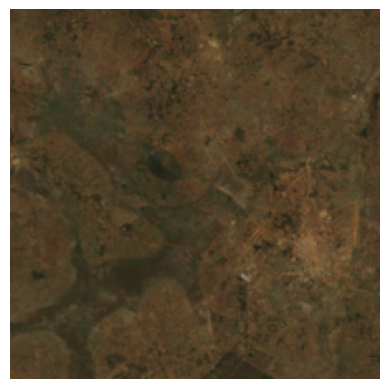

In [58]:
import numpy as np
import matplotlib.pyplot as plt

row = df.iloc[59916]
img_path = os.path.join(DATA_DIR, 'dhs_images', row['cluster_id'], 'landsat.np')
img = np.load(img_path)
img = np.clip(img * 0.0000275 - 0.2, 0.0, 0.3) / 0.3
plt.imshow(img[:,:,[2, 1, 0]])
plt.axis('off')
plt.show()

---

## Turn into CLIP embeddings

In [61]:
import torch
from transformers import CLIPProcessor, CLIPModel
from tqdm import tqdm

OUTPUT_EMBEDDINGS_FILE = os.path.join(DATA_DIR, "new_clip_embeddings.npy")
MODEL_NAME = "flax-community/clip-rsicd"
BATCH_SIZE = 4  # Adjust this based on GPU memory capacity

# Load the pretrained model and processor from huggingface
model = CLIPModel.from_pretrained(MODEL_NAME).to("cuda")
processor = CLIPProcessor.from_pretrained(MODEL_NAME)

embeddings = []

# Helper function to process a batch of images and return embeddings
def process_batch(image_batch):
    inputs = processor(images=image_batch, return_tensors="pt", padding=True).to("cuda")
    with torch.no_grad():
        batch_features = model.get_image_features(**inputs).cpu().numpy()  # Move back to CPU for numpy
    return batch_features

# Process images
image_batch = []
for _, row in tqdm(df.iterrows(), total=len(df), desc="Processing Images"):
    
    # Read image
    img_path = os.path.join(DATA_DIR, 'dhs_images', row['cluster_id'], 'landsat.np')
    img = np.load(img_path)
    img = img[..., [2, 1, 0]] # Extract RED, GREEN, and BLUE channels (indices 2, 1, 0 respectively)
    img = img.transpose(2, 0, 1) # Transpose to get channel first (3, 224, 224)
    img = np.clip(img * 0.0000275 - 0.2, 0.0, 0.3) / 0.3
    image_batch.append(img)

    # Process the batch if it reaches the batch size
    if len(image_batch) == BATCH_SIZE:
        batch_embeddings = process_batch(image_batch)
        embeddings.append(batch_embeddings)
        image_batch = []  # Reset batch list

# Process any remaining images that didn’t complete a full batch
if image_batch:
    batch_embeddings = process_batch(image_batch)
    embeddings.append(batch_embeddings)

# Save the embeddings array as a .npy file
embeddings_array = np.vstack(embeddings)
np.save(OUTPUT_EMBEDDINGS_FILE, embeddings_array)

print(f"Embeddings saved to {OUTPUT_EMBEDDINGS_FILE}.")

Processing Images: 100%|██████████| 68075/68075 [54:55<00:00, 20.66it/s]  


Embeddings saved to /mimer/NOBACKUP/groups/globalpoverty1/markus/impute_aware_ate/new_clip_embeddings.npy.
